_Get rid of last example (oscillator) - instead maybe discuss transforms vs functions once more. Add in an example of recurrence without any f' and g' and what the outputs would be. this drives home the why._

## ECE495 Intro to programming neurons with Nengo: Dynamics

In this demonstration we will:

1. Understand and implement recurrence in a Nengo network
2. Create an integrator with neurons
3. Create an oscillator with neurons

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal

### Recurrence in Nengo

Recurrence in neural networks can be used to implement stable dynamics. Such dynamics are important for memory, noise cleanup, statistical inference, and many other dynamic transformations. Recurrent neurons can also be used if you will be performing the same computation over and over again within an algorithm (i.e. just build the neuron once and send in different inputs). Another use of recurrent neurons is online learning (edge computing), depending on the algorithm.

We have discussed how to compute the neuron representation of a signal in depth (i.e. decode the spikes). As it turns out, this is something we did in ECE 346. Any guesses?

Imagine this is a block diagram:  
$u(t)$ --> [$h(t)$] --> $x(t)$

Where $u(t)$ is our input, $h(t)$ is our transfer function, and $x(t)$ is the transformed input (or state of the system). Here, math tells us that $x(t)=u(t)*h(t)$ where $u(t)$ is our output spikes, $h(t)$ is our neuron action potential, and $x(t)$ is our decoded signal. _This is how we (and Nengo) have decoded our spikes!_

In the case where we are considering $u(t)$ to be spikes, convolution is not terribly difficult - we've been doing it for two weeks! However, if we begin to think of our outputs as an input signal (at the algorithm level), convolution gets complicated. Therefore, we want to use.... _Laplace Transforms_.

$$\mathscr{L}\{x(t)\} = X(s)= U(s)H(s)$$
This is now just multiplication!

Fun fact: if the membrane action potential is approximated as $h(t)=e^{-t/\tau}$ - which is how Nengo approximates it - the Laplace is:

$$\mathscr{L}\{h(t)\}=\frac{1}{1+s\tau}$$

If we plut $H(s)$ into $X(s)=U(s)H(s)$ and rearrange a bit, we get the following:

$$sX(s) = \frac{1}{\tau}(U(s)-X(s))$$

The Inverse Laplace of $sX(s)$ is $\dot{x}$, which we can use to describe the dynamics of our system (i.e. how much we've changed over time)! 

$$\dot{x(t)}=-\frac{1}{\tau}(x(t))-u(t))$$

This is a lot of math, but this is simply what we did in our Jupyter Notebook on Neuron Representation. $\tau$ is the rate at which we change and $x(t)-u(t)$ is the total change in our system over time (output-input). You can go back to our very first example and see how $\tau$ impacts the rate at which we change over time as we move toward the value we intend to represent.


#### Okay, but WHY?!

Well, this lays the foundation for implementing recurrence using neurons. AND it again shows you how useful ECE346 actually was, even if it was brutal along the way. 

Now, we are going to feedback our output state x(t) to our input - you hopefully can recall implementing feedback in block diagrams from ECE346. We will use some Laplace math to determine the functions that will be implemented in our feedback connections in Nengo.

#### Why feedback?

I mentioned that recurrent neurons can be used to implement stable dynamics. Recall our synapse values - when they're larger, the neurons more accurately represent our signal but it takes a while to get there. Smaller is noiser but faster. However, biological systems only offer synpatic time constants of about 2-200ms. If we decide to stay true to biological systems when we model our algorithms (totally your call), recurrence can enable larger $\tau$ for the network itself. This means that if our neuron synapses are .005s in our neuron ensemble, we can feed the output of our neuron back to itself with a particular set of dynamics such that the network itself responds at a synaptic time constant of .5 instead! Let's see how this works. In order to do so, we must math...

Now, our block diagram has a feedback from $x(t)$ back to the input line, with a function of $f(x(t))$ attached to the feedback line. If we ignore any external input $u(t)$ and assess the dynamics alone, we get the same thing as last time, except now we have $f(x(t))$ instead of $u(t)$ (because $f(x(t))$ is now the input if there's not external input $u(t)$).

$$\dot{x}(t)=-\frac{1}{\tau}(x(t))-f(x(t)))$$

But we know we will have an external input! We will call our external input $g(u(t))$. So now, we simply add $g(u(t))+f(x(t))$ and call that our input, which updates our $\dot{x}(t)$ to:

$$\dot{x}(t)=-\frac{1}{\tau}(x(t))-g(u(t))-f(x(t)))=\frac{1}{\tau}(f(x(t)+g(u(t)))-x(t))$$

Here's the deal about controls - it's heavily studied and instead of tring to see what we get, we can instead say what we want to get and go from there. For simplicity of notation, we will drop all $t$ s. 

We choose

$$\dot{x}=f(x)+g(u)$$

meaning our state is simply the feedback of $f(x)$ added to our input $g(u)$. In this case, we want our output to be the representation of our input, just getting there more gradually than the neurons themselves would get us there (i.e. slower but accurate). Therefore, we create a new function that will get us to $\dot{x}(t)=f(x)+g(u)= \frac{1}{\tau}(f(x(t)+g(u(t)))-x(t))$, and that is:

$$\dot{f}+\dot{g}=\tau (f(x) + g(u) +x)$$

And we replace $f(x)+g(u)$ with $\dot{f}(x)+\dot{g}(u)$:

$$\dot{x}(t)=\frac{1}{\tau}([\tau (f(x) + g(u) +x)]-x))=f(x)+g(u)$$

Recall, we want $\dot{x}=f(x)+g(u)$ and we got there! Now we just need a $\dot{f}$ and a $\dot{g}$ to make that happen. These two functions achieve the dynamics we are looking for:

$$\dot{f}(x(t))=\tau f(x(t)) + x(t)$$
$$\dot{g}(u)=\tau g(u)$$ 

These two functions are what we will use at our connections in our Nengo model!

#### Let's actually do that now!

Suppose we want the following dynamics in our system (i.e. our entire network):

$$\dot{x}=-\frac{1}{.05}(x(t)-u(t))$$

This means that we want our network time constant to be $.05$ regardless of our neuron synaptic time constants. Yes... we could just adjust each neurons time constants, but for one reason or another, maybe that's not accessible to us.

Instead, we need to implement the dynamics we just derived to make that happen, where $f(x)=-\frac{x}{.05}$ and $g(u)=\frac{u}{.05}$:

$$\dot{f}=-\frac{\tau}{.05}x + x$$
$$\dot{g}=\frac{\tau}{.05}u$$

These will be the functions used in our Nengo network to achieve the desired dynamics, with $\dot{f}$ being the feed forward function and $\dot{g}$ being the feedback function.



In [2]:
model = nengo.Network(label="Recurrence")

synaptic_tau = .005 # actual neuron tau, much smaller, responds quickly but noisily
desired_tau = .05 # much larger, therefore more stable for network as a whole

with model:
    a = nengo.Ensemble(100, dimensions=1)

    stim = nengo.Node(Piecewise({0: 0, 1: 1}))
    nengo.Connection(stim, a)

    b = nengo.Ensemble(100, dimensions=1)

    def forward(u):
        return (synaptic_tau/desired_tau)*u
    
    nengo.Connection(a, b, function = forward, synapse=synaptic_tau)

    def recurrent(x):
        return (1-synaptic_tau/desired_tau)*x
    
    nengo.Connection(b, b, function=recurrent, synapse=synaptic_tau)


Probe it, run it, plot it

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

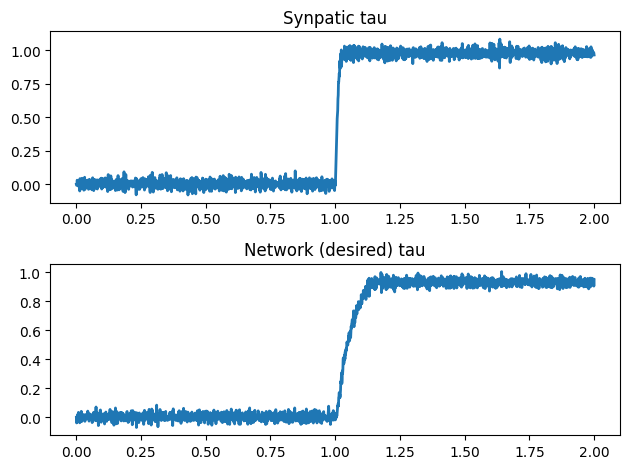

In [3]:
with model:
    a_probe = nengo.Probe(a, synapse=synaptic_tau)
    b_probe = nengo.Probe(b, synapse=synaptic_tau)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 6 seconds
    sim.run(2)

# Plot the decoded output of the ensemble
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[a_probe], lw=2)
plt.title("Synpatic tau")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[b_probe], lw=2)
plt.title("Network (desired) tau")
plt.tight_layout()

#### Discussion

In the plots, you can see that the neurons themselves have a shorter time constant than that of the network. We can choose any synaptic time constant for your neurons and you'll get the same results for the network using this dynamical system. **Try it!**

That was a whole lot of math to do something pretty simple in Nengo. BUT I wanted you to understand how the functions were determined. Ultimately, whatever dynamics we want our system to have can be achieved using a feedback of some sort with the right associated functions. 

Let's keep going with two more examples.

### Integrator

This is a simple example of a recurrent network to create an integrator, which essentially builds memory with neurons. Integrators are biologically plausible. In fact, we have neurons that perform this function to convert velocity signals (horizontal and vertical movements) into eye position commands (where you want your eye to go based on velocity). The interesting thing about integrators is that the neuron output remains the same even if the input is 0 and only moves again if the input becomes non-zero (i.e. once your eye goes to the top-left, it doesn't drift back to center until you decide it should). Now, think through this in terms of feedback to decide if this is intuitive to you. We will then be able to see this in our output plots.

In terms of dynamics, we start with this linear dynamical system:

$$\dot{x}=f(x)+g(u)=Ax+Bu $$

where $x$ is again our output state, $u$ is our input, and $A$ and $B$ determine the direction/strenght of $x$ and $u$ contributions. We only want our outputs to change as a result of our input and we want to remember our prior input when the current input is 0. Therefore, A=0 and B=I. This tells us that at every point in time, the change to our state is the input as expected per our above definition of an integrator. 

We must define functions for our feed forward and feedback aspects of our recurring network:

$$\dot{f}(x)= \tau f(x) + x = \tau Ax + x = x$$
$$\dot{g}(u)=\tau g(u)  =\tau Bu = \tau Iu =\tau u$$ 

For this example, our input is a piecewise function so you can see that the output is integrating (i.e. summing over time) the input. Note that since the integrator constantly sums its input, it will saturate quickly if you leave the input non-zero. This makes it clear that neurons have a finite range of representation. Such saturation effects however can be exploited to perform useful computations (e.g. soft normalization).

You'll notice we call an argument `transform` instead of `function` in our connections. Because we simply multiply $x$ and $u$ by 1 and $\tau$ respectively (a linear transformation), we can use the `transform` argument, which may be simpler than spending time defining a function. However, for cases in which your function is more complicated (such as implementing a reLU - i.e. a nonlinear transformation), the `function` argument will be the way to go. Read more about this [here](https://www.nengo.ai/nengo/connections.html). If this isn't intuitive to you, feel free to instead define functions. You can always define a function and use `function` for your connections; however, note that there are cases (non-linear transformations / more complicated functions) in which `transform` will not work.

In [4]:
model = nengo.Network(label="Integrator")
with model:
    # create the recurrent neuron ensemble
    A = nengo.Ensemble(100, dimensions=1)

    # create piecewise input
    input = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))

    # Using a long time constant for stability (less noise)
    tau = 0.1 
    
    # if you wanted to define functions, they might look like this
    #def forward(u):
    #    return tau*u
    #def recurrent(x):
    #    return x

    # Connect the population to itself
    nengo.Connection(A, A, transform=[[1]], synapse=tau)  
    
    # Connect the input
    # The same time constant as recurrent to make it more 'ideal'
    nengo.Connection(input, A, transform=[[tau]], synapse=tau)  

#### Probe it and Run it

In [5]:
with model:
    # Add probes
    input_probe = nengo.Probe(input)
    A_probe = nengo.Probe(A, synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 6 seconds
    sim.run(6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Plot it

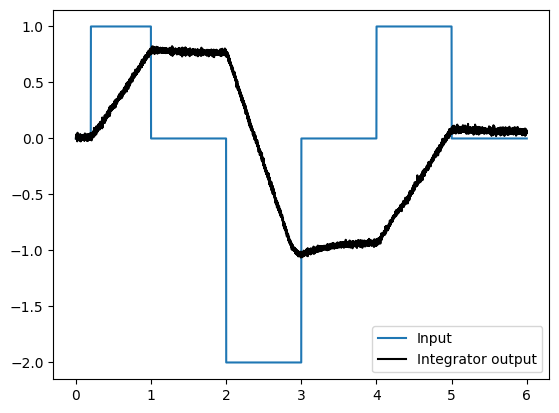

In [6]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Input")
plt.plot(sim.trange(), sim.data[A_probe], "k", label="Integrator output")
plt.legend()

#### Discussion

The graph shows the response to the input by the integrator. Because it is implemented in neurons, it will not be perfect (i.e. there will be drift). Running several times will give a sense of the kinds of drift you might expect. Drift can be reduced by increasing the number of neurons, using a larger time constant (100-200ms work pretty well for feedback), or changing the inputs more rapidly.

Intuition check: this integrator function is _not_ trying to represent the input signal. Instead, you can think of the input signal as a velocity at which you are moving until the input changes or becomes zero. When the input becomes zero, you can see the "memory" at play. Think through this in terms of eye movement, where the input signal is the velocity at which your eye is moving. 

### Working Memory

An integrator is certainly biologically plausible and useful; however, what if we want to reset the value that's being stored to zero (not wait for the position based on velocity to slowly get there AND THEN have to turn off velocity at just the right time step)?

We can do that since we now understand feedback, how to design an integrator, and multiplication (from neuron_transformations). In this case, we have a system with these dynamics:

$$ \dot{x} = \alpha Ax + Bu $$

where $\dot{x}$ is our memory, our input is $u$, and our control is $\alpha$. Our control determines when we store our input state and clear our controlled storage, which is where multiplication comes into play. If you make $\alpha$ a negative value, it will clear the state gradually back to zero. More negative values for the controller clear it to zero more quickly. The idea here is that instead of feeding back $x$ like in our integrator, we feedback something like $-x+x$ to feedback less than x such that we decay back to zero. If $\alpha$ is instead zero, we implement the integrator itself, where we feedback $0+x$ just as before.

Notice that the control $\alpha$ has no impact on the input itself! So if $u$ is zero and $\alpha$ is 0, we hold steady at the value. If $u$ is zero and $alpha$ is negative, we decay to zero. If $u$ is nonzero and $\alpha$ is negative, once $u$ becomes zero again, the output will decay to zero.

The functions for our feed forward and feedback aspects of our recurring network look similar to those prior, except now we want for our feedback to negate the x if we are in storage mode. Therefore, $A=I$ and $\alpha$ is either 0 or negative:

$$\dot{f}(x)= \tau f(x) + x = \tau \alpha Ax + x = \tau \alpha Ix + x = \tau \alpha x + x$$
$$\dot{g}(u)=\tau g(u)  =\tau Bu = \tau Iu =\tau u$$ 

Notice that our feedback function is now non-linear! Meaning we need a 2D neuron ensemble to take in both $u$ and $\alpha$.

In [7]:
model = nengo.Network(label="Memory")
with model:
    
    # create piecewise input u
    input_u = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 3: 0, 4: 1, 5: 0}))

    # create piecewise input for controller (consists of 0s and negative values)
    input_control = nengo.Node(Piecewise({0: 0, 2: -.25, 3: -1, 4: -1, 5: 0}))    

    # create the recurrent neuron ensemble that recieves the above two inputs
    memory = nengo.Ensemble(500, dimensions=2)

    # Using a long time constant for stability (less noise)
    tau = 0.1 
    
    # if you wanted to define a function for feedforward, it might look like this
    #def forward(u):
    #    return tau*u

    # feedback function - this is nonlinear and harder for neurons to approximate!
    #  increase neurons to help 
    def recurrent(state):
        alpha, x = state
        return tau*alpha*x + x 

    # Create the connection for the controller to the memory ensemble
    nengo.Connection(input_control,memory[0])
    
    # Connect the input to the memory ensemble - feed forward (this remains the same!)
    # The same time constant as recurrent to make it more 'ideal'
    nengo.Connection(input_u, memory[1], transform=[[tau]], synapse=tau) 

    # Connect the population to itself - feedback
    #  we only want this to impact the u value going in! NOT the controller
    nengo.Connection(memory, memory[1], function=recurrent, synapse=tau)  

#### Probe it and Run it

In [8]:
with model:
    # Add probes
    input_probe = nengo.Probe(input_u)
    control_probe = nengo.Probe(input_control)
    mem_probe = nengo.Probe(memory, synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 6 seconds
    sim.run(6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Plot it

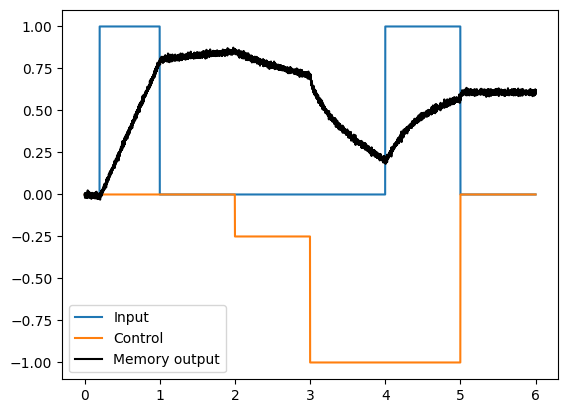

In [9]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Input")
plt.plot(sim.trange(), sim.data[control_probe], label="Control")
plt.plot(sim.trange(), sim.data[mem_probe][:,1], "k", label="Memory output")
plt.legend()

#### Discussion

The more negative $\alpha$ is, the faster it decays to zero (you can see this transition within 2-4 seconds). You can also see from 4-5 seconds that if you have non-zero values for both $u$ and $\alpha$, you won't have a linear change in position. Recall drift to account for times when both $u$ and $\alpha$ are zero (1-2 seconds and 5-6 seconds).

### Simple Oscillator

Have you had to do some physics math regarding a spring on a block that's sliding on a frictionless surface? Or a pendullum? These are good examples of simple harmonic oscillators, and we can implement these using recurrent neurons! Turns out this is also biologically plausible - think of repetitive or rhythmic movements (walking, chewing, etc) - and neurons have been measured to show this oscillatory behavior for comparable movements in fish. 

Let's work through a spring on a block that slides on a frictionless surface. Here, we have 

$$F=-kx=ma=m\ddot{x}$$

where $x$ is position, $F$ is the force applied to the block, $k$ is our spring constant, $m$ is our mass of the object, and $\ddot{x}$ is acceleration of the mass as a result of force. This can be rearranged to a 2nd order ODE:

$$ \ddot{x}+\frac{k}{m}x=0 $$

This looks different than the other examples we've done where $\dot{x}=f(x)+g(u)=Ax+Bu$. First, we will assume an unforced oscillator, therefore $Bu$ goes to 0. We'd now like to rewrite our problem in the form of $\dot{x}=Ax$. Let $\omega=\sqrt{\frac{k}{m}}$. With some magical math, we can get something that looks like that form:

$$\begin{bmatrix}
    \dot{x}_0 \\
    \dot{x}_1 
\end{bmatrix} = \begin{bmatrix}
		            0 & \omega \\
		            -\omega & 0  
	            \end{bmatrix} \begin{bmatrix}
                                    x_0 \\
                                    x_1 
                                \end{bmatrix}$$

Let's now take that back to defining our feed forward and feedback functions:

$$\dot{f}(x)= \tau f(x) + x = \tau Ax + x = \begin{bmatrix}
		            0 & \tau \omega \\
		            -\tau \omega & 0  
	            \end{bmatrix}\begin{bmatrix}
                                    x_0 \\
                                    x_1 
                                \end{bmatrix}+ \begin{bmatrix}
                                                    x_0 \\
                                                    x_1 
                                                \end{bmatrix}= \begin{bmatrix}
                                                                    \tau \omega x_1 + x_0 \\
                                                                    -\tau \omega x_0 +x_1
                                                                \end{bmatrix}$$
$$\dot{g}(u)=\tau g(u)  =\tau Bu = 0$$ 

To implement $\begin{bmatrix}
                \tau x_1 + x_0 \\
                -\tau x_0 +x_1
            \end{bmatrix}$ in Nengo, we can use the `transform` argument to get the matrix $\begin{bmatrix}
                                                                                                1 & \tau \omega \\
                                                                                                -\tau\omega & 1
                                                                                            \end{bmatrix}$.

We will provide a brief input signal to trigger the oscillatory behavior of the neural representation as the two dimensions interact (i.e. $x[0]=1$ for .1 seconds, otherwise everything is 0).

In [10]:
# Create the model object
model = nengo.Network(label="Oscillator")

tau = .1
omega = 10

with model:
    # Create the ensemble for the oscillator
    neurons = nengo.Ensemble(200, dimensions=2)

    # Create an input signal
    # x0 is 1 for .1s, x0 and x1 are 0 otherwise
    input = nengo.Node(Piecewise({0: [1, 0], 0.1: [0, 0]}))

    # Connect the input signal to the neural ensemble
    nengo.Connection(input, neurons)

    # Create the feedback connection using our transform matrix
    nengo.Connection(neurons, neurons, transform=[[1, tau*omega], [-tau*omega, 1]], synapse=0.1)

    # You could define a function and use that instead of transform
    #def recurrent(x):
    #    return [tau*omega*x[1]+x[0],-tau*omega*x[0]+x[1]]
    #nengo.Connection(neurons, neurons, function=recurrent, synapse=0.1)

Probe it, run it, plot it.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

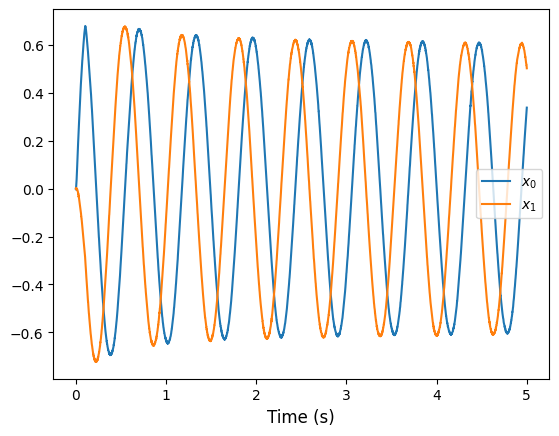

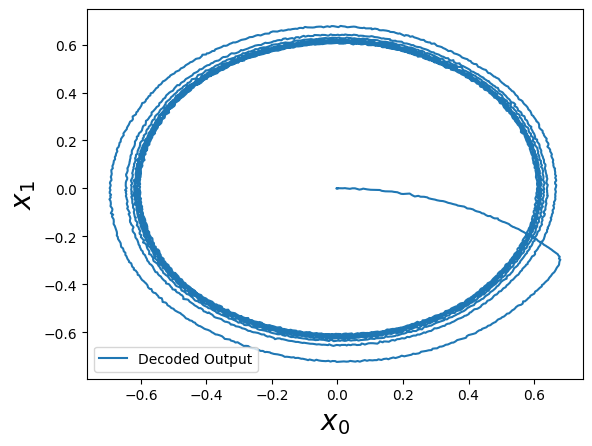

In [11]:
with model:
    input_probe = nengo.Probe(input, "output")
    neuron_probe = nengo.Probe(neurons, "decoded_output", synapse=0.1)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)

plt.figure()
plt.plot(sim.trange(), sim.data[neuron_probe])
plt.xlabel("Time (s)", fontsize="large")
plt.legend(["$x_0$", "$x_1$"])

data = sim.data[neuron_probe]
plt.figure()
plt.plot(data[:, 0], data[:, 1], label="Decoded Output")
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$", fontsize=20)
plt.legend()

#### Discussion

If we look at the changes to $\dot{x}$, we can see that $\dot{x}_0 = \omega x_1$ and $\dot{x}_1 = -\omega x_0$
$$\begin{bmatrix}
    \dot{x}_0 \\
    \dot{x}_1 
\end{bmatrix} = \begin{bmatrix}
		            0 & \omega \\
		            -\omega & 0  
	            \end{bmatrix} \begin{bmatrix}
                                    x_0 \\
                                    x_1 
                                \end{bmatrix}$$
                                
In both plots, you can see that as $x_0$ gets more positive, $x_1$ gets more negative and vice versa. Recall the earlier notes on the synapses for the recurrent neurons. Smaller time constants will cause significant drift. Larger time constants will decrease the drift. **Try it!**

We can also adjust the $\omega$ term to change the frequency of oscillation. We do so by (Nengo) learning new decoder weights! **Try it!**

An example for a [controlled oscillator](https://www.nengo.ai/nengo/examples/dynamics/controlled-oscillator.html) is available online and is a far more elegant example. The above example does not have an additional input that controls the frequency of the oscillations. Instead, once things are kicked off they keep going at the same frequency until the amplitudes decay back to zero. 

### Resources

Other dynamics tutorials [can be found here](https://www.nengo.ai/nengo/examples.html#building-dynamical-systems).  
Every example we cover in this notebook can be found [in this video](https://youtu.be/Fl4cfZCie-w?si=eSyLzeAu2jluMFZ3) if you would like an alternate teaching method to assist in your understanding of the concept.
